# Machine Learning Engineer Nanodegree

## Capstone Project

### Project: Semantic similarity extraction using word vectors in Mahabharata dataset

Welcome to the capstone project of the Machine Learning Engineer Nanodegree! In this notebook, we will use corpus of words from Mahabharata is used as an input to create word vectors using word2vec, with the help of t-SNE, reduce the dimensions of the word vectors and finally use cosine similarity to analyze semantic similarities, i.e. to answer relationship questions based on the learning. The end solution of this project will be to analyze relationships and logics in the dataset. 

The dataset for this project can be found on the [GitHub Mahabharata Machine Learning Repository](https://github.com/TilakD/Mahabharata_extract-semantic-similarities_Natural-languageprocessing/tree/master/Dataset)

Model is assessed using the real facts about the data set, to benchmark the model I have compiled 23 relationship facts and will be adding few more as I build the model. For example, below are a few of the real data used to benchmark the model.
Dhritarastra is related to Pandu, as Sahadeva is related to Nakula

    Bhima is related to Arjuna, as Ambalika is related to Ambika
    Pandu is related to Kunti, as Dhritarashtra is related to Gandhari
    Bhima is related to Draupadi, as Arjuna is related to Chitrangada
    Karna is related to Kunti, as Duryodhana is related to Gandhari
    .
    .
    .


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Exploring the Data
Run the code cell below to load necessary Python libraries.

In [1]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
#word encoding
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system
import os
#pretty print, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec   (conda install -c anaconda gensim=1.0.1)
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

C:\Users\DTILAK\AppData\Local\Continuum\Anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Set up logging

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Download NLTK tokenizer models (only the first time)

In [5]:
##stopwords like the at a an, unnecesasry
##tokenization into sentences, punkt 
##http://www.nltk.org/

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing Corpus
### Load all 18 books

In [6]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\*.txt"))
print("Found books:")
book_filenames

Found books:


['..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\1.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\10.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\11.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\12.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\13.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\14.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\15.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\16.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\17.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input\\18.txt',
 '..\\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\\input

### Combine the books into one string

In [7]:
#initialize raw unicode , we'll add all text to this file in memory
corpus_raw = u""

#for each book, read it, open it in utf 8 format, 
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print ("Corpus is now {0} characters long".format(len(corpus_raw)))
    print ()

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\1.txt'...
Corpus is now 295412 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\10.txt'...
Corpus is now 325640 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\11.txt'...
Corpus is now 337972 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\12.txt'...
Corpus is now 364937 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\13.txt'...
Corpus is now 390015 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\14.txt'...
Corpus is now 404662 characters long

Reading '..\Mahabharata_extract-semantic-similarities_Natural-languageprocessing\input\15.txt'...
Corpus is now 417222 characters long

Reading '..\Mahabharata_extract-semantic-similari

### Split the corpus into sentences

In [8]:
#tokenizastion
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [10]:
#convert into a list of words
#remove unnnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [11]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [12]:
# Example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Above all these qualities, he was a devoted servant of Lord Vishnu, and therefore he was given the title, "King of kings".
[u'Above', u'all', u'these', u'qualities', u'he', u'was', u'a', u'devoted', u'servant', u'of', u'Lord', u'Vishnu', u'and', u'therefore', u'he', u'was', u'given', u'the', u'title', u'King', u'of', u'kings']


In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 293,755 tokens


### Build model

In [14]:
# Dimensionality of the resulting word vectors.
# more dimensions, more computationally expensive to train
# but also more accurate
# more dimensions = more generalized
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
# 0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the random number generator, to make the results reproducible.
seed = 1

In [15]:
mahabharata2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [16]:
mahabharata2vec.build_vocab(sentences)

2017-03-26 00:19:27,486 : INFO : collecting all words and their counts
2017-03-26 00:19:27,486 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-03-26 00:19:27,539 : INFO : PROGRESS: at sentence #10000, processed 165878 words, keeping 9238 word types
2017-03-26 00:19:27,571 : INFO : collected 11439 word types from a corpus of 293755 raw words and 17725 sentences
2017-03-26 00:19:27,572 : INFO : Loading a fresh vocabulary
2017-03-26 00:19:27,595 : INFO : min_count=3 retains 5703 unique words (49% of original 11439, drops 5736)
2017-03-26 00:19:27,599 : INFO : min_count=3 leaves 286413 word corpus (97% of original 293755, drops 7342)
2017-03-26 00:19:27,628 : INFO : deleting the raw counts dictionary of 11439 items
2017-03-26 00:19:27,631 : INFO : sample=0.001 downsamples 52 most-common words
2017-03-26 00:19:27,631 : INFO : downsampling leaves estimated 214323 word corpus (74.8% of prior 286413)
2017-03-26 00:19:27,632 : INFO : estimated required memory for

In [17]:
print("Word2Vec vocabulary length:", len(mahabharata2vec.wv.vocab))

Word2Vec vocabulary length: 5703


## word2vec training, this might take a minute

In [18]:
mahabharata2vec.train(sentences)

2017-03-26 00:19:28,000 : INFO : training model with 4 workers on 5703 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-03-26 00:19:28,000 : INFO : expecting 17725 sentences, matching count from corpus used for vocabulary survey
2017-03-26 00:19:29,051 : INFO : PROGRESS: at 13.96% examples, 144508 words/s, in_qsize 7, out_qsize 0
2017-03-26 00:19:30,085 : INFO : PROGRESS: at 30.57% examples, 158340 words/s, in_qsize 7, out_qsize 0
2017-03-26 00:19:31,105 : INFO : PROGRESS: at 46.91% examples, 163128 words/s, in_qsize 8, out_qsize 0
2017-03-26 00:19:32,092 : INFO : PROGRESS: at 63.28% examples, 166141 words/s, in_qsize 7, out_qsize 0
2017-03-26 00:19:33,095 : INFO : PROGRESS: at 78.86% examples, 166235 words/s, in_qsize 7, out_qsize 0
2017-03-26 00:19:34,099 : INFO : PROGRESS: at 94.92% examples, 167285 words/s, in_qsize 7, out_qsize 0
2017-03-26 00:19:34,295 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-03-26 00:19:34,299 : IN

1071411

### Save to file, can be useful later

In [19]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [20]:
mahabharata2vec.save(os.path.join("trained", "mahabharata2vec.w2v"))

2017-03-26 00:19:34,546 : INFO : saving Word2Vec object under trained\mahabharata2vec.w2v, separately None
2017-03-26 00:19:34,549 : INFO : not storing attribute syn0norm
2017-03-26 00:19:34,549 : INFO : not storing attribute cum_table
2017-03-26 00:19:34,634 : INFO : saved trained\mahabharata2vec.w2v


In [21]:
mahabharata2vec = w2v.Word2Vec.load(os.path.join("trained", "mahabharata2vec.w2v"))

2017-03-26 00:19:34,650 : INFO : loading Word2Vec object from trained\mahabharata2vec.w2v
2017-03-26 00:19:34,739 : INFO : loading wv recursively from trained\mahabharata2vec.w2v.wv.* with mmap=None
2017-03-26 00:19:34,740 : INFO : setting ignored attribute syn0norm to None
2017-03-26 00:19:34,740 : INFO : setting ignored attribute cum_table to None
2017-03-26 00:19:34,742 : INFO : loaded trained\mahabharata2vec.w2v


### Compress the word vectors into 3D space using t-SNE and plot them for further analysis

In [22]:
tsne = sklearn.manifold.TSNE(n_components=3,perplexity=50.0, n_iter=20000,random_state=0)

In [23]:
all_word_vectors_matrix = mahabharata2vec.wv.syn0

### Train t-SNE, this could take few minute...

In [24]:
all_word_vectors_matrix_3d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [25]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_3d[mahabharata2vec.wv.vocab[word].index])
            for word in mahabharata2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [26]:
if not os.path.exists("points_output"):
    os.makedirs("points_output")
points.to_csv(os.path.join("points_output", "points_threeD.csv"), sep=',')

In [27]:
points.head(10)

,word,x,y,z
0,raining,2.440782,-3.781715,6.341077
1,yellow,0.135900,-1.592791,3.715994
2,four,-3.114904,-1.684896,1.066440
3,woods,3.671948,-4.533481,4.882453
4,hanging,0.776443,-2.996524,5.847064
5,looking,2.693209,-1.055264,3.698760
6,granting,3.959299,-4.137763,3.009252
7,eligible,-0.143341,-6.795673,0.910814
8,Kundadahara,1.694689,-2.463388,7.485629
9,lord,5.636792,-2.601213,0.995256


In [28]:
sns.set_context("poster")

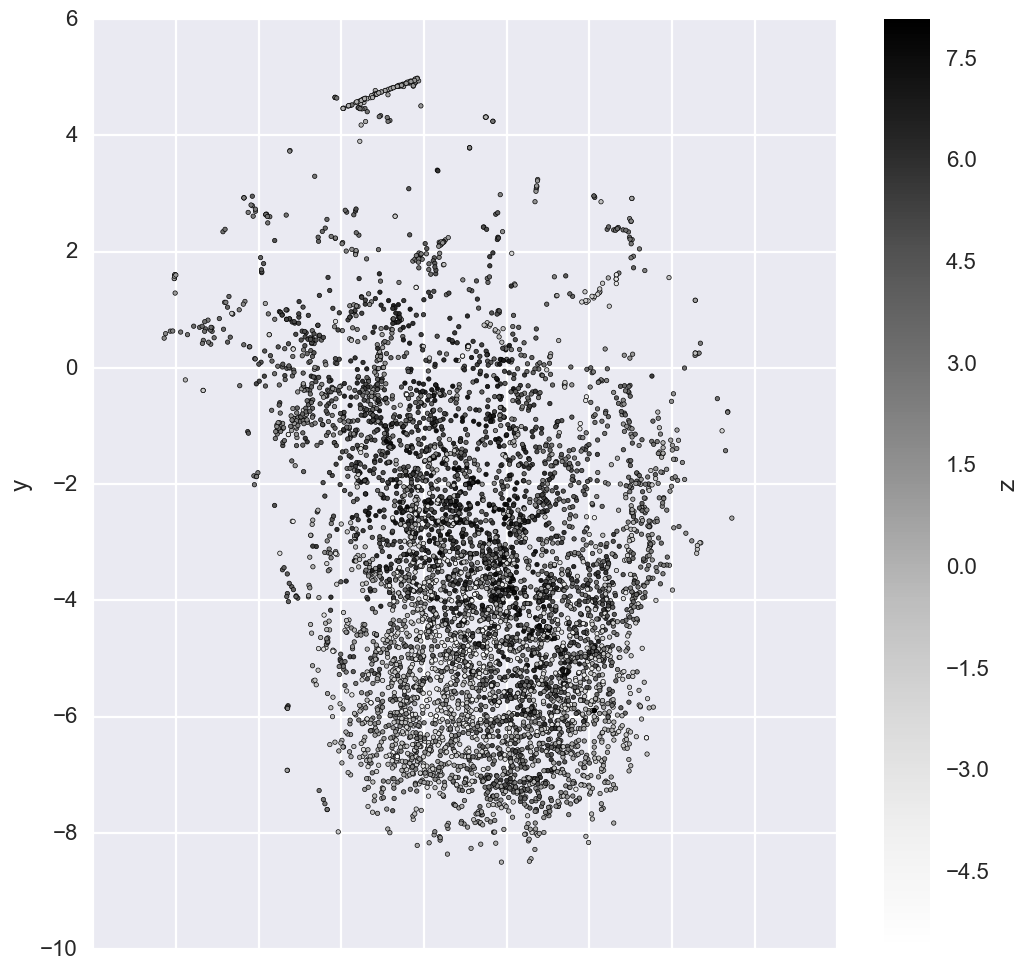

In [29]:
points.plot.scatter("x", "y", c = "z",s=10, figsize=(12, 12))

### Proper noun extraction, to get a good picture of all the characters in the book.

In [45]:
all_words = points.word
all_words_df = pd.DataFrame(all_words)
all_words_list = all_words_df['word'].values.tolist()
str_words = ' '.join(all_words_list)
#str_words

In [132]:
essays = str_words
tokens = nltk.word_tokenize(essays)
tagged = nltk.pos_tag(tokens)
nouns = [word for word,pos in tagged if (pos == 'NNP') or (pos == 'NNPS')]
print ("Number of nouns is {}.".format(len(nouns)))

#join into a string
joined = "\n".join(nouns).encode('utf-8')
into_string = str(nouns)

#write in an csv file
output = open("Proper_noun.csv", "w")
output.write(joined)
output.close()

#print as a table
noun_string = " ".join(nouns).encode('utf-8')
nouns_df = pd.DataFrame(nouns)
nouns_df.head(10)

Number of nouns is 836.


(-0.5, 1439.5, 1079.5, -0.5)

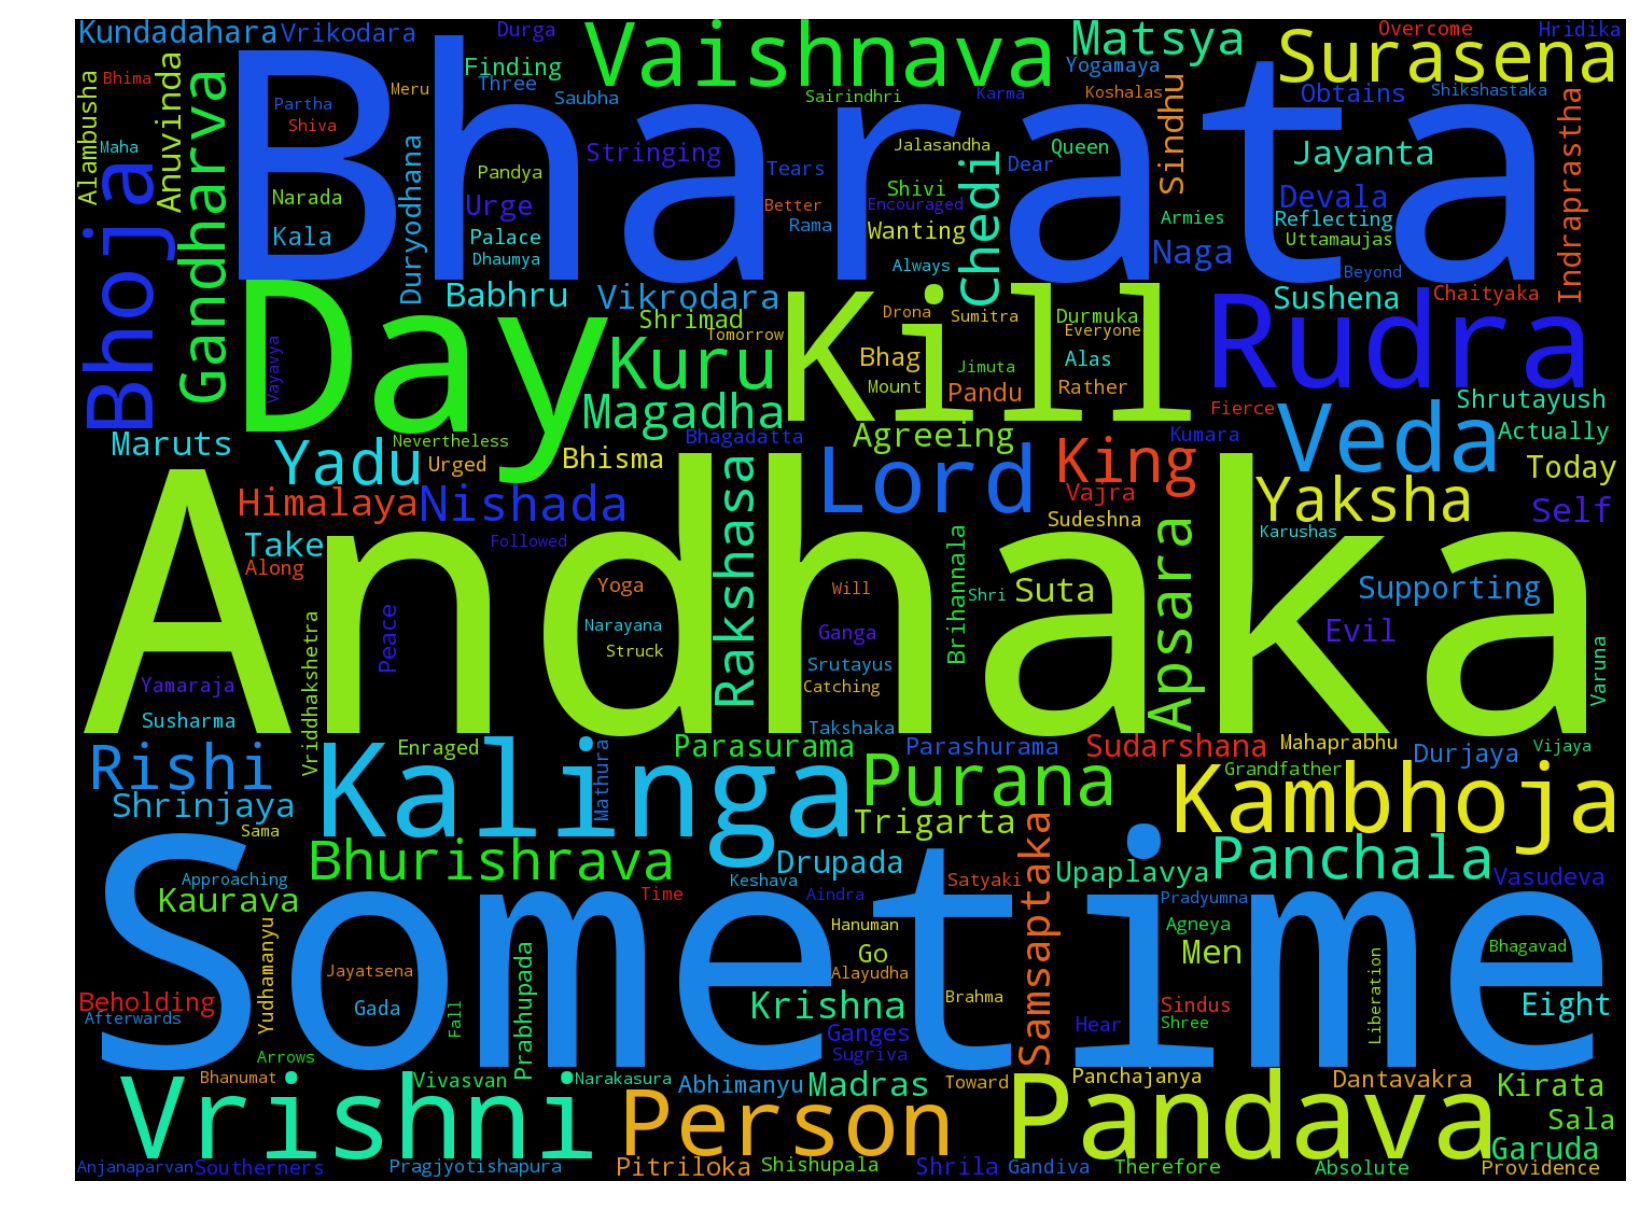

In [133]:
#conda install -c conda-forge wordcloud=1.2.1
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(noun_string)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [134]:
number_noun = 0
noun_points = pd.DataFrame()
noun_string_to_word = sentence_to_wordlist(noun_string)
all_words = points.word

for noun_wrd in range(len(noun_string_to_word)):
    for wrd_sl_no in range(len(points)):
        if noun_string_to_word[noun_wrd] == all_words[wrd_sl_no]:
            noun_points_old = points.iloc[[wrd_sl_no]]
            noun_points = noun_points.append(noun_points_old)


In [135]:
type(noun_points)
#print (noun_points)
noun_points.to_csv(os.path.join("points_output", "noun_points_threeD.csv"), sep=',')

#### Scatter plot of all the proper nouns

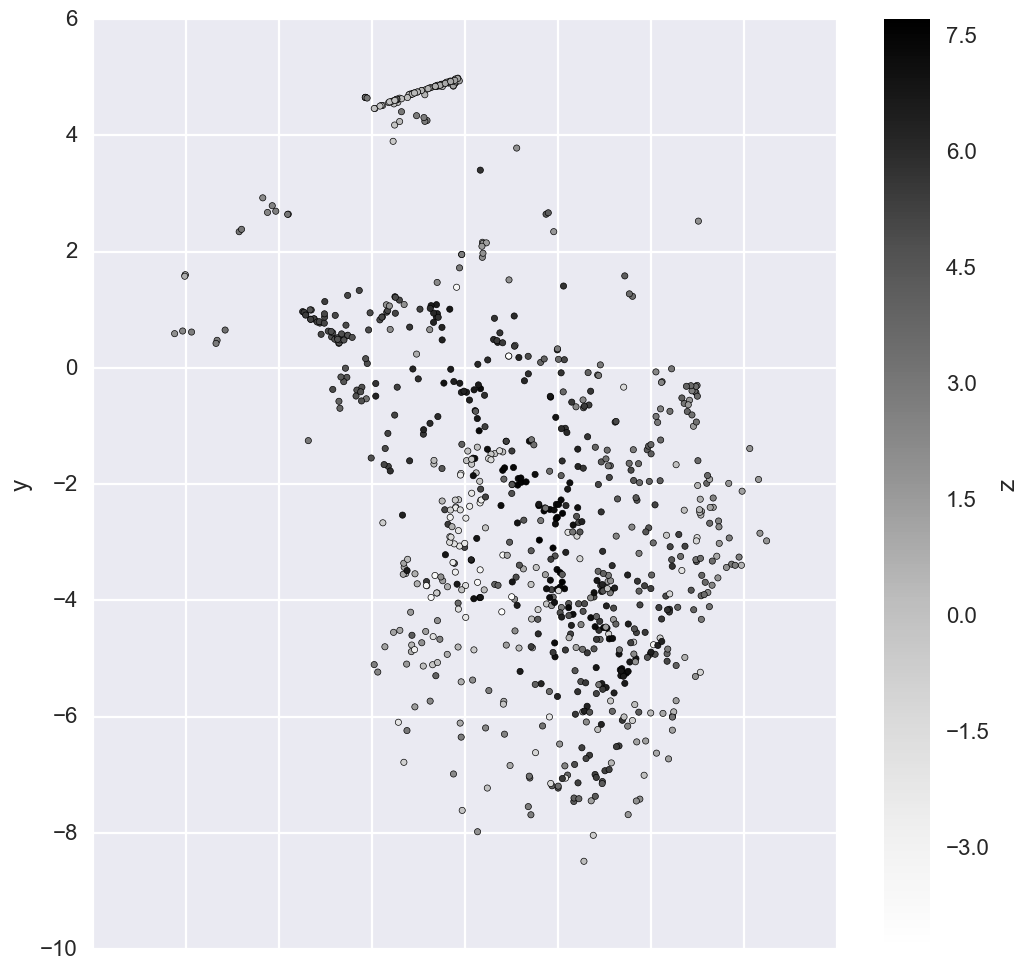

In [136]:
noun_points.plot.scatter("x", "y", c = "z", s=20, figsize=(12, 12))

#### Lets zoom in to see related characters in the book

In [71]:
def plot_region(x_bounds, y_bounds, z_bounds):
    slice = noun_points[
        (x_bounds[0] <= noun_points.x) &
        (noun_points.x <= x_bounds[1]) & 
        (y_bounds[0] <= noun_points.y) &
        (noun_points.y <= y_bounds[1]) &
        (z_bounds[0] <= noun_points.z) &
        (noun_points.z <= z_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", c = "z",s=35, figsize=(15, 15))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

#### Pandavas and Kauravas are cousines, so they are nearby

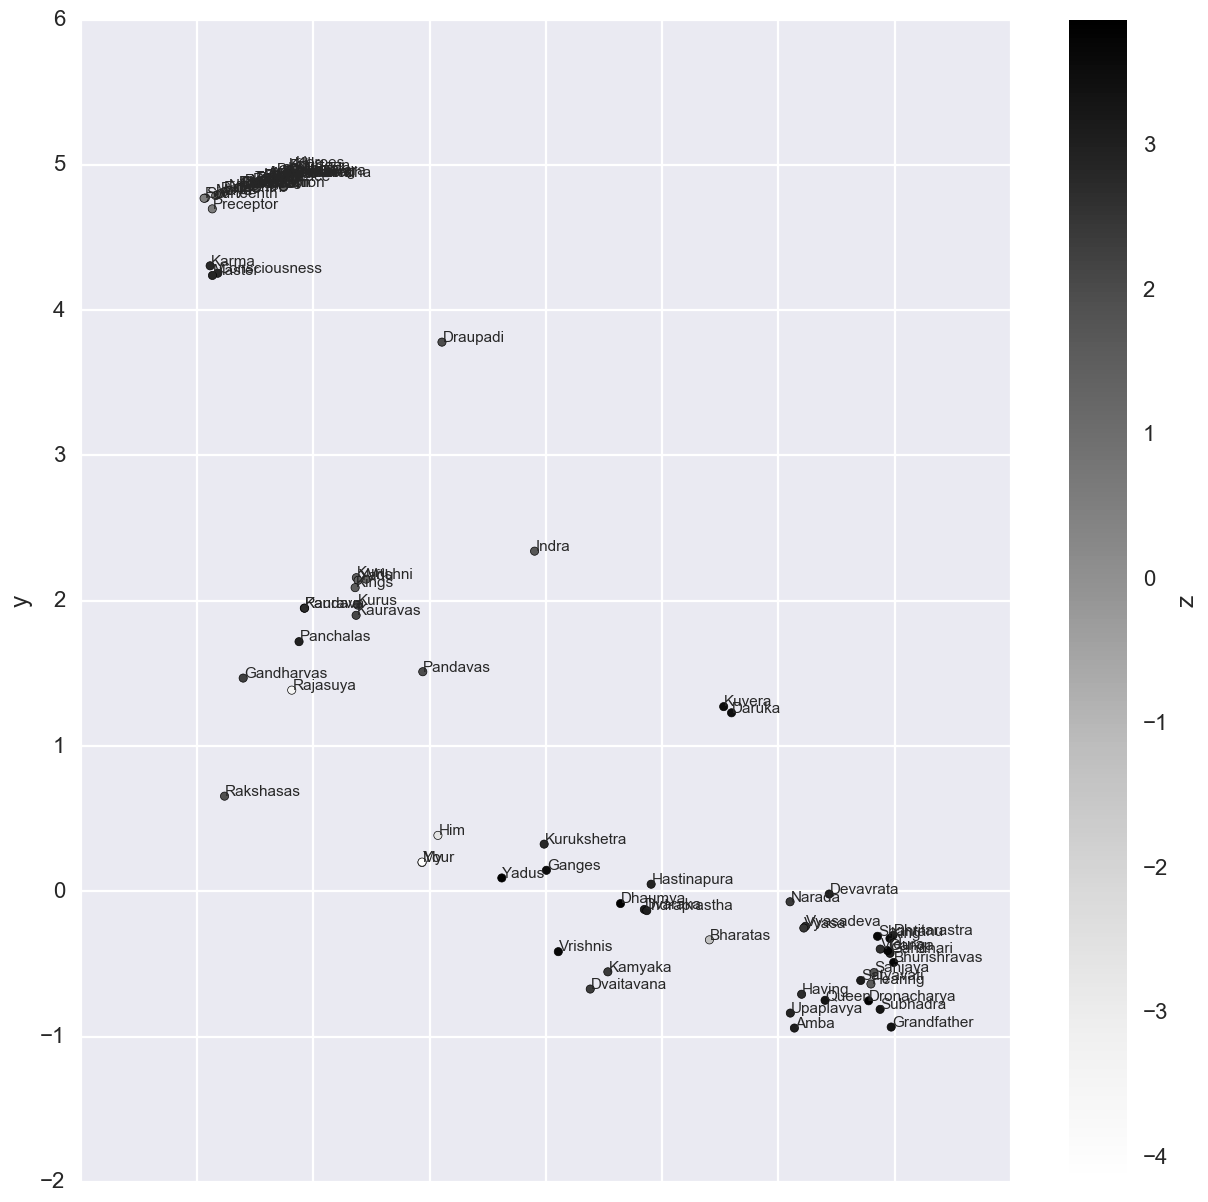

In [72]:
plot_region(x_bounds=(-1, 5), y_bounds=(-1,5), z_bounds=(-5,3.9))

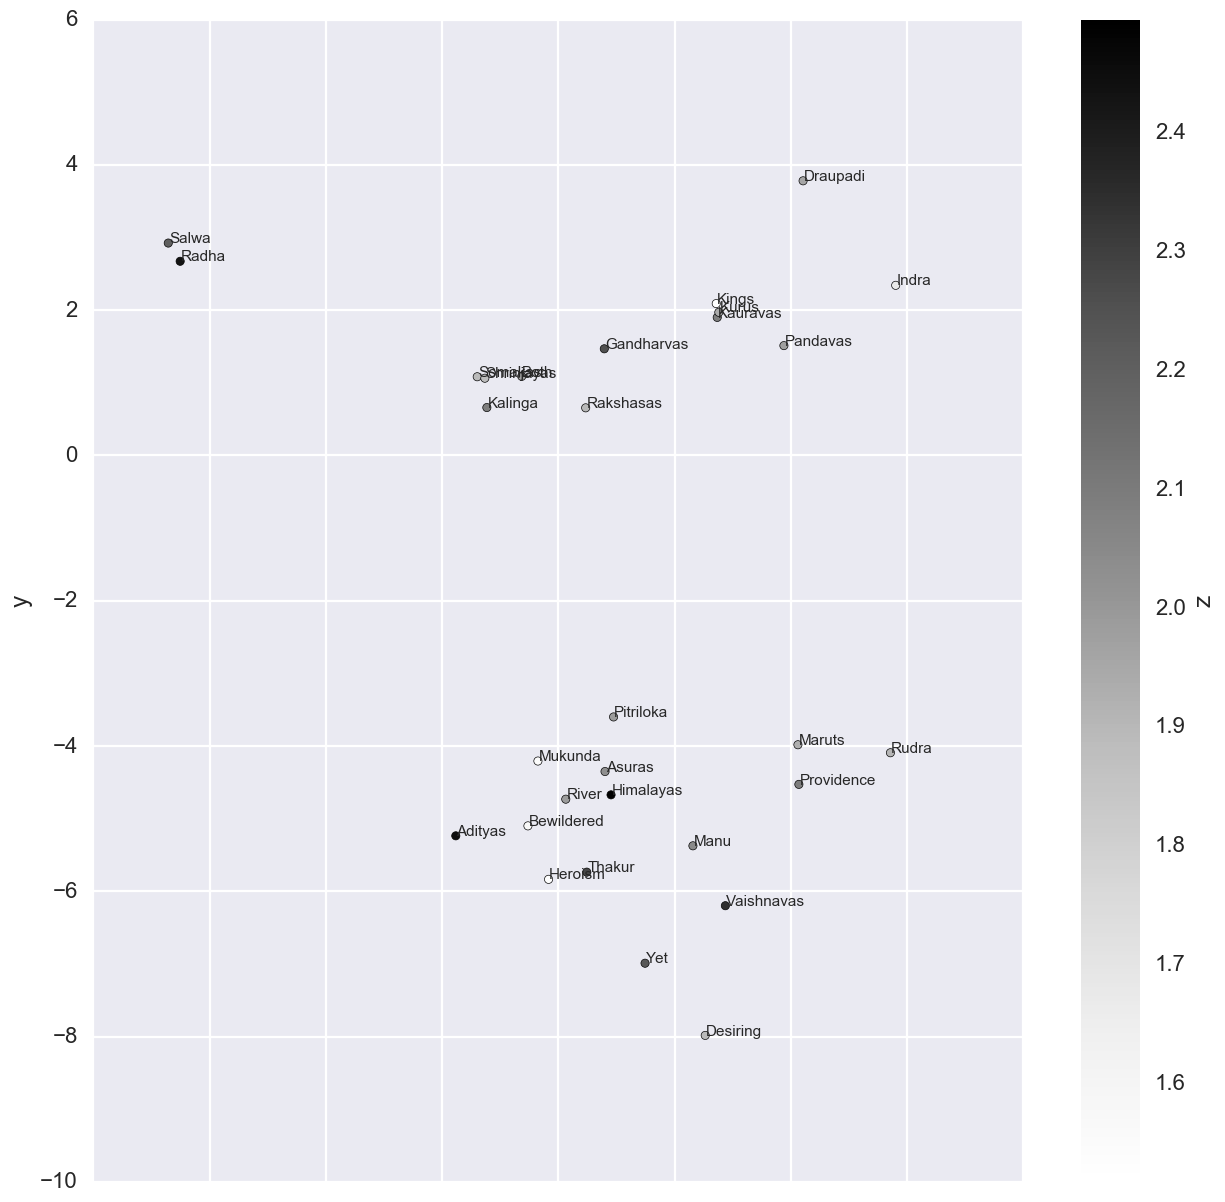

In [73]:
# Nakula and Sahadeva are brothers 
plot_region(x_bounds=(-5, 2), y_bounds=(-8,5), z_bounds=(1.5,2.5))


#### Explore semantic similarities between book characters. Words closest to the given word

In [74]:
mahabharata2vec.most_similar("Krishna")

[(u'Balarama', 0.8368571400642395),
 (u'Rama', 0.7953585982322693),
 (u'mantra', 0.786412239074707),
 (u'Shri', 0.7840003371238708),
 (u'Maha', 0.7758504748344421),
 (u'Daruka', 0.7699847221374512),
 (u'Shiva', 0.7679664492607117),
 (u'maha', 0.7653331756591797),
 (u'Baladeva', 0.7550551295280457),
 (u'Brahma', 0.7490764856338501)]

In [75]:
mahabharata2vec.most_similar("Arjuna")

[(u'Partha', 0.8511461615562439),
 (u'Daruka', 0.7956963181495667),
 (u'Satyaki', 0.7796871066093445),
 (u'Karna', 0.7748898863792419),
 (u'Bhima', 0.7712571620941162),
 (u'Pradyumna', 0.7690628170967102),
 (u'Parashurama', 0.7580252289772034),
 (u'Kuvera', 0.7565227746963501),
 (u'Shishupala', 0.7460328936576843),
 (u'Shalva', 0.7457205057144165)]

In [76]:
mahabharata2vec.most_similar("Karna")

[(u'Ashvatthama', 0.9217157959938049),
 (u'Salya', 0.897223949432373),
 (u'Drona', 0.8899939656257629),
 (u'Bhishma', 0.8866386413574219),
 (u'Kripa', 0.8794238567352295),
 (u'Duryodhana', 0.8645515441894531),
 (u'Satyaki', 0.8551504015922546),
 (u'Jayadratha', 0.8530725836753845),
 (u'Kritavarman', 0.8529332876205444),
 (u'Shakuni', 0.849739134311676)]

In [87]:
mahabharata2vec.most_similar("Kundadahara")

[(u'Visalakha', 0.9962617754936218),
 (u'Suvahu', 0.9951159358024597),
 (u'joints', 0.9917425513267517),
 (u'Adityaketu', 0.9914873838424683),
 (u'chakras', 0.991317629814148),
 (u'badly', 0.9907129406929016),
 (u'Mahodara', 0.990252673625946),
 (u'Sakradeva', 0.9888915419578552),
 (u'Sushena', 0.9886748194694519),
 (u'gloves', 0.9876887798309326)]

#### Answer relationship questions

In [78]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = mahabharata2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [79]:
nearest_similarity_cosmul("Dhritarastra" ,"Pandu", "Nakula") # Brother 
nearest_similarity_cosmul("Bhima" ,"Arjuna", "Ambika") # sibling 
nearest_similarity_cosmul("Pandu" ,"Kunti", "Gandhari") # spouse 
nearest_similarity_cosmul("Bhima" ,"Draupadi", "Chitrangada") # wife
nearest_similarity_cosmul("Karna" ,"Kunti", "Gandhari") # spouse
nearest_similarity_cosmul("Bhima" ,"Draupadi", "Subhadra") # spouse
nearest_similarity_cosmul("Yudhisthira" ,"Kunti", "Gandhari") #son
nearest_similarity_cosmul("Bhima" ,"Kunti", "Madri") # son
nearest_similarity_cosmul("Bhima" ,"Draupadi", "Ulupi") #spouse
nearest_similarity_cosmul("Vichitravirya" ,"Ambalika", "Ambika") # spouse
nearest_similarity_cosmul("Bhima" ,"Ghatotkacha", "Abhimanyu") # son
nearest_similarity_cosmul("Bhima" ,"Draupadi", "Draupadi") # spouse

Dhritarastra is related to Pandu, as Sahadeva is related to Nakula
Bhima is related to Arjuna, as Kuntibhoja is related to Ambika
Pandu is related to Kunti, as Dhritarastra is related to Gandhari
Bhima is related to Draupadi, as invoked is related to Chitrangada
Karna is related to Kunti, as Kripa is related to Gandhari
Bhima is related to Draupadi, as Partha is related to Subhadra
Yudhisthira is related to Kunti, as Duryodhana is related to Gandhari
Bhima is related to Kunti, as Vikarna is related to Madri
Bhima is related to Draupadi, as Partha is related to Ulupi
Vichitravirya is related to Ambalika, as Svayamvara is related to Ambika
Bhima is related to Ghatotkacha, as Satyaki is related to Abhimanyu
Bhima is related to Draupadi, as Satyaki is related to Draupadi


u'Satyaki'